In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp evaluation

## Overview

This section provides evaluation schemes for both Numerai Classic and Signals.
The `Evaluator` takes a `NumerFrame` as input and returns a Pandas DataFrame containing metrics for each given prediction column.

In [ ]:
#| export
import time
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Union
from numerapi import SignalsAPI
from rich import print as rich_print

from numerblox.numerframe import NumerFrame, create_numerframe
from numerblox.postprocessing import FeatureNeutralizer
from numerblox.key import Key

2023-04-24 22:13:32.713026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 22:13:34.261400: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-24 22:13:36.842357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-24 22:13:36.842531: W tensorflow/stream_executor

In [ ]:
#| export
#| include: false

# Main feature set for FNC calculation. From v4.1/features.json/medium
FNCV4_FEATURES = ["feature_honoured_observational_balaamite", "feature_polaroid_vadose_quinze", "feature_untidy_withdrawn_bargeman", "feature_genuine_kyphotic_trehala", "feature_unenthralled_sportful_schoolhouse", "feature_divulsive_explanatory_ideologue", "feature_ichthyotic_roofed_yeshiva", "feature_waggly_outlandish_carbonisation", "feature_floriated_amish_sprite", "feature_iconoclastic_parietal_agonist", "feature_demolished_unfrightened_superpower", "feature_styloid_subdermal_cytotoxin", "feature_ironfisted_nonvintage_chlorpromazine", "feature_torose_unspiritualised_kylie", "feature_tearing_unkingly_adulthood", "feature_stylolitic_brown_spume", "feature_ferial_incumbent_engraving", "feature_litigant_unsizable_rhebok", "feature_floatiest_quintuplicate_carpentering", "feature_tuberculate_patelliform_paging", "feature_cuddlesome_undernamed_incidental", "feature_loony_zirconic_hoofer", "feature_indign_tardier_borough", "feature_fair_papal_vinaigrette", "feature_attack_unlit_milling", "feature_froggier_unlearned_underworkman", "feature_peninsular_pulsatile_vapor", "feature_midmost_perspiratory_hubert", "feature_laminable_unspecified_gynoecium", "feature_bally_bathymetrical_isadora", "feature_skim_unmeant_bandsman", "feature_ungenuine_sporophytic_evangelist", "feature_supercelestial_telic_dyfed", "feature_inconsiderate_unbooted_ricer", "feature_inured_conservable_forcer", "feature_glibber_deficient_jakarta", "feature_morbific_irredentist_interregnum", "feature_conjoint_transverse_superstructure", "feature_tingling_large_primordiality", "feature_phyllopod_unconstrainable_blubberer", "feature_deformable_unitary_schistosity", "feature_unprovisioned_aquatic_deuterogamy", "feature_equipped_undoubted_athanasian", "feature_inflammable_numb_anticline", "feature_kinky_benzal_holotype", "feature_ruptured_designing_interpolator", "feature_hierologic_expectable_maiolica", "feature_boiling_won_rama", "feature_lovelorn_aided_limiter", "feature_soviet_zibeline_profiler", "feature_altimetrical_muddled_symbolism", "feature_bratty_disrespectable_bookstand", "feature_unshaken_ahorse_wehrmacht", "feature_mightier_chivalric_kana", "feature_gambrel_unblessed_gigantomachy", "feature_ethiopic_anhedonic_stob", "feature_overstrung_dysmenorrheal_ingolstadt", "feature_rose_buttoned_dandy", "feature_recipient_perched_dendrochronologist", "feature_spikier_ordinate_taira", "feature_mercian_luddite_aganippe", "feature_faint_consociate_rhytidectomy", "feature_unpressed_mahratta_dah", "feature_maxillary_orphic_despicability", "feature_clasping_fast_menstruation", "feature_obeliscal_bewildered_reviewer", "feature_babist_moribund_myna", "feature_underdressed_tanagrine_prying", "feature_corniest_undue_scall", "feature_reduplicative_appalling_metastable", "feature_wrathful_prolix_colotomy", "feature_limonitic_issuable_melancholy", "feature_approximal_telautographic_sharkskin", "feature_fribble_gusseted_stickjaw", "feature_spec_subversive_plotter", "feature_unsinkable_dumbstruck_octuplet", "feature_integrative_reviviscent_governed", "feature_tamil_grungy_empathy", "feature_canopic_exigible_schoolgirl", "feature_plumular_constantinian_repositing", "feature_serpentiform_trinary_imponderability", "feature_gyroidal_embowed_pilcher", "feature_unlivable_armenian_wedge", "feature_flawed_demonological_toady", "feature_pruinose_raploch_roubaix", "feature_seediest_ramshackle_reclamation", "feature_hagiological_refer_vitamin", "feature_alcibiadean_lumpier_origan", "feature_encased_unamiable_hasidism", "feature_evocable_woollen_guarder", "feature_hunchbacked_unturning_meditation", "feature_circumnavigable_naughty_retranslation", "feature_testicular_slashed_ventosity", "feature_potential_subsessile_disconnection", "feature_unswaddled_inenarrable_goody", "feature_stellular_paler_centralisation", "feature_angevin_fitful_sultan", "feature_subinfeudatory_brainy_carmel", "feature_simpatico_cadential_pup", "feature_esculent_erotic_epoxy", "feature_milliary_hyperpyretic_medea", "feature_coraciiform_sciurine_reef", "feature_weightiest_protozoic_brawler", "feature_cooled_perkiest_electrodeposition", "feature_differing_peptizing_womaniser", "feature_gleaming_monosyllabic_scrod", "feature_unyielding_dismal_divertissement", "feature_rankine_meaty_port", "feature_southernmost_unhuman_arbiter", "feature_singhalese_cerographical_ego", "feature_malignant_campodeid_pluton", "feature_dure_jaspery_mugging", "feature_educational_caustic_mythologisation", "feature_diverted_astral_dunghill", "feature_degenerate_diaphragmatic_literalizer", "feature_laced_scraggly_grimalkin", "feature_wheezier_unjaundiced_game", "feature_unimpressed_uninflected_theophylline", "feature_shiite_overfed_mense", "feature_irritant_reciprocal_pelage", "feature_bricky_runed_bottleful", "feature_phyletic_separate_genuflexion", "feature_peckish_impetrative_kanpur", "feature_unshrinking_semiarid_floccule", "feature_heartier_salverform_nephew", "feature_geostrophic_adaptative_karla", "feature_navigational_enured_condensability", "feature_confusable_pursy_plosion", "feature_clenched_wayward_coelostat", "feature_developed_arbitrary_traditionalist", "feature_unnameable_abysmal_net", "feature_completive_pedantical_sinecurist", "feature_witchy_orange_muley", "feature_misfeatured_sometime_tunneler", "feature_agaze_lancinate_zohar", "feature_subservient_wedged_limping", "feature_urticant_ultracentrifugal_wane", "feature_pulverized_unified_dupery", "feature_stoichiometric_unanswerable_leveller", "feature_cyanophyte_emasculated_turpin", "feature_unruly_salian_impetuosity", "feature_ataractic_swept_rubeola", "feature_pansophical_agitato_theatricality", "feature_recreational_homiletic_nubian", "feature_burning_phrygian_axinomancy", "feature_protractive_moral_forswearing", "feature_certificated_putrescent_godship", "feature_dietetic_unscholarly_methamphetamine", "feature_vegetable_manlier_macaco", "feature_anthropoid_pithy_newscast", "feature_verifying_imagism_sublease", "feature_deckled_exaggerative_algol", "feature_songful_intercostal_frightener", "feature_additive_untrustworthy_hierologist", "feature_translative_quantitative_eschewer", "feature_coseismic_surpassable_invariance", "feature_blubbery_octahedral_bushfire", "feature_continued_conjugated_natalia", "feature_dissident_templed_shippon", "feature_wally_unrotted_eccrinology", "feature_unforgivable_airtight_reinsurance", "feature_unrelenting_intravascular_mesenchyme", "feature_linear_scummiest_insobriety", "feature_ovine_bramblier_leaven", "feature_uninforming_predictable_pepino", "feature_pluviometrical_biannual_saiga", "feature_affettuoso_taxidermic_greg", "feature_lateral_confervoid_belgravia", "feature_coalier_hircine_brokerage", "feature_undiverted_analyzed_accidie", "feature_favourable_swankiest_tympanist", "feature_refractory_topped_dependance", "feature_bustled_fieriest_doukhobor", "feature_isobilateral_olden_nephron", "feature_circassian_leathern_impugner", "feature_signed_ringent_sunna", "feature_cornute_potentiometric_tinhorn", "feature_veristic_parklike_halcyon", "feature_geochemical_unsavoury_collection", "feature_guerrilla_arrested_flavine", "feature_undependable_stedfast_donegal", "feature_bijou_penetrant_syringa", "feature_lamarckian_tarnal_egestion", "feature_horticultural_footworn_superscription", "feature_unwithered_personate_dilatation", "feature_wrought_muckier_temporality", "feature_rival_undepraved_countermarch", "feature_irrevocable_unlawful_oral", "feature_flawy_caller_superior", "feature_elohistic_totalitarian_underline", "feature_unrecognisable_waxier_paging", "feature_paraffinoid_flashiest_brotherhood", "feature_depauperate_armipotent_decentralisation", "feature_received_veiniest_tamarix", "feature_scissile_dejected_kainite", "feature_narcotized_collectivist_evzone", "feature_jamesian_scutiform_ionium", "feature_gambogian_feudalist_diocletian", "feature_moneyed_mesophytic_lester", "feature_purblind_autarkic_pyrenoid", "feature_paleolithic_myalgic_lech", "feature_fortyish_neptunian_catechumenate", "feature_tricksiest_pending_voile", "feature_forcipate_laced_greenlet", "feature_overjoyed_undriven_sauna", "feature_small_cumulative_graywacke", "feature_incertain_catchable_zibet", "feature_ruthenic_peremptory_truth", "feature_blind_concordant_tribalist", "feature_strigose_rugose_interjector", "feature_binding_lanky_rushing", "feature_carolean_tearable_smoothie", "feature_nappiest_unportioned_readjustment", "feature_sarmatia_foldable_eutectic", "feature_plum_anemometrical_guessing", "feature_gubernacular_liguloid_frankie", "feature_castigatory_hundredfold_hearthrug", "feature_pennsylvanian_sibylic_chanoyu", "feature_unreaving_intensive_docudrama", "feature_relinquished_incognizable_batholith", "feature_indusiate_canned_cosh", "feature_maglemosian_kittle_coachbuilding", "feature_unreeling_homeothermic_macedonia", "feature_asteriated_invigorated_penitence", "feature_anucleate_knotted_nonage", "feature_shrinelike_unreplaceable_nitrogenization", "feature_lacerable_backmost_vaseline", "feature_unreceipted_latest_lesser", "feature_unimaginable_sec_kaka", "feature_goidelic_gobelin_ledge", "feature_incondite_undisappointing_telephotograph", "feature_concoctive_symmetric_abulia", "feature_anglophobic_unformed_maneuverer", "feature_gravimetric_ski_enigma", "feature_balmiest_spinal_roundelay", "feature_required_bibliological_tonga", "feature_amoroso_wimpish_maturing", "feature_exertive_unmodernised_scaup", "feature_rude_booziest_ilium", "feature_uncompelled_curvy_amerindian", "feature_septuple_bonapartean_sanbenito", "feature_tottery_unmetalled_codder", "feature_tachygraphical_sedimentological_mesoderm", "feature_adsorbed_blizzardy_burlesque", "feature_wistful_tussive_cycloserine", "feature_superjacent_grubby_axillary", "feature_biological_caprine_cannoneer", "feature_unreversed_fain_jute", "feature_unexalted_rebel_kofta", "feature_doggish_mouthwatering_abelard", "feature_forfeit_contributing_joinder", "feature_necked_moresque_lowell", "feature_footling_unpuckered_lophophore", "feature_thorniest_laughable_hindustani", "feature_hotter_cattish_aridity", "feature_developing_behind_joan", "feature_ectodermal_mandaean_saffian", "feature_crimpier_gude_housedog", "feature_probationary_readying_roundelay", "feature_inserted_inconvertible_functioning", "feature_manifold_melodramatic_girl", "feature_drizzling_refrigerative_imperfection", "feature_sardonic_primary_shadwell", "feature_monocyclic_galliambic_par", "feature_smutty_prohibited_sullivan", "feature_productile_auriform_fil", "feature_accommodable_crinite_cleft", "feature_clipped_kurdish_grainer", "feature_dustproof_unafraid_stampede", "feature_neutered_postpositive_writ", "feature_twelve_haphazard_pantography", "feature_riskier_ended_typo", "feature_smaller_colored_immurement", "feature_snatchy_xylic_institution", "feature_conchal_angriest_oophyte", "feature_multiseriate_oak_benzidine", "feature_gobioid_transhuman_interconnection", "feature_reservable_peristomal_emden", "feature_inestimable_unmoral_extraversion", "feature_nubby_sissified_value", "feature_incorporating_abominable_daily", "feature_herbaged_brownish_consubstantialist", "feature_solemn_wordier_needlework", "feature_evangelistic_cruel_dissimilitude", "feature_impetratory_shuttered_chewer", "feature_referenced_biliteral_chiropody", "feature_eleatic_fellow_auctioneer", "feature_malpighian_vaporized_biogen", "feature_expiscatory_wriest_colportage", "feature_yelled_hysteretic_eath", "feature_bitterish_buttocked_turtleneck", "feature_percipient_atelectatic_cinnamon", "feature_gobony_premonitory_twinkler", "feature_twittery_tai_attainment", "feature_crooked_wally_lobation", "feature_crookback_workable_infringement", "feature_brawling_unpeppered_comedian", "feature_glyphographic_reparable_empyrean", "feature_noctilucent_subcortical_proportionality", "feature_guardian_frore_rolling", "feature_denuded_typed_wattmeter", "feature_unreachable_neritic_saracen", "feature_enzymatic_poorest_advocaat", "feature_wariest_vulnerable_unmorality", "feature_guttering_half_spondee", "feature_distressed_bloated_disquietude", "feature_leaky_overloaded_rhodium", "feature_unsapped_anionic_catherine", "feature_kissable_forfeit_egotism", "feature_unsizable_ancestral_collocutor", "feature_healthier_unconnected_clave", "feature_cirsoid_buddhism_vespa", "feature_rid_conveyable_cinchonization", "feature_donsie_folkish_renitency", "feature_agee_sold_microhabitat", "feature_newfangled_huddled_gest", "feature_clandestine_inkiest_silkworm", "feature_unutterable_softening_roper", "feature_balaamitical_electropositive_exhaustibility", "feature_unvalued_untangled_keener", "feature_undisturbing_quadrifid_reinhardt", "feature_bucked_costume_malagasy", "feature_joint_unreturning_basalt", "feature_coordinate_shyer_evildoing", "feature_carunculate_discursive_hectare", "feature_cynic_unreckonable_feoffment", "feature_cnidarian_micrologic_sousaphone", "feature_unperceivable_unrumpled_appendant", "feature_dissolvable_chrismal_obtund", "feature_choosier_uncongenial_coachwood", "feature_grimmest_prostate_doctrinaire", "feature_granulative_uncritical_agostini", "feature_convalescence_deuteranopic_lemuroid", "feature_disintegrable_snakier_zion", "feature_thoughtful_accommodable_lack", "feature_basophil_urdy_matzo", "feature_repellant_unwanted_clarinetist", "feature_antimonarchist_ordainable_quarterage", "feature_hardback_saturnalian_cyclometer", "feature_mythic_florentine_psammite", "feature_serpentiform_incomplete_bessarabia", "feature_unappeasable_employed_photoelectron", "feature_seaboard_adducent_polynesian", "feature_genoese_uncreditable_subregion", "feature_dexter_unstifled_snoring", "feature_protonematal_springtime_varioloid", "feature_orchitic_reported_coloration", "feature_stelliform_curling_trawler", "feature_athenian_pragmatism_isomorphism", "feature_abating_unadaptable_weakfish", "feature_instructional_desensitized_symmetallism", "feature_disarrayed_rarefactive_trisulphide", "feature_partible_amphibrachic_classicism", "feature_ecstatic_foundational_crinoidea", "feature_unimproved_courtliest_uncongeniality", "feature_cosy_microtonal_cedar", "feature_heedful_argyle_russianization", "feature_unhonoured_detested_xenocryst", "feature_sicker_spelaean_endplay", "feature_coordinated_astir_vituperation", "feature_stratocratic_aerodynamic_herero", "feature_uneasy_unaccommodating_immortality", "feature_professional_platonic_marten", "feature_detrital_respected_parlance", "feature_contraceptive_cartelist_beast", "feature_tapestried_madding_acclimatiser", "feature_optic_mycelial_whimper", "feature_liftable_direful_polyploid", "feature_objective_micro_langton", "feature_entopic_interpreted_subsidiary", "feature_saclike_hyphal_postulator", "feature_recent_shorty_preferment", "feature_strip_honoured_trail", "feature_unsheltered_doughtiest_episiotomy", "feature_acclimatisable_unfeigned_maghreb", "feature_galactopoietic_luckiest_protecting", "feature_scarcest_vaporized_max", "feature_spicier_unstripped_initial", "feature_hooly_chekhovian_phytogeographer", "feature_smouldering_underground_wingspan", "feature_phantasmal_extenuative_britain", "feature_sciurine_stibial_lintwhite", "feature_eucharistic_widowed_misfeasance", "feature_libratory_seizable_orlando", "feature_brackish_obstructed_almighty", "feature_translucid_neuroanatomical_sego", "feature_unheeded_stylar_planarian", "feature_preceptive_rushed_swedenborgian", "feature_sumerian_descendible_kalpa", "feature_jazziest_spellbinding_philabeg", "feature_dormie_sodden_steed", "feature_directoire_propositional_clydebank", "feature_triangled_rubber_skein", "feature_vendean_thwartwise_resistant", "feature_preoral_tonsorial_souk", "feature_virescent_telugu_neighbour", "feature_prefigurative_downstream_transvaluation", "feature_undepreciated_partitive_ipomoea", "feature_coactive_bandoleered_trogon", "feature_southerly_assonant_amicability", "feature_cortical_halt_catcher", "feature_antarthritic_syzygial_wonderland", "feature_revitalizing_rutilant_swastika", "feature_holy_chic_cali", "feature_hermitical_stark_serfhood", "feature_deformable_productile_piglet", "feature_lentissimo_ducky_quadroon", "feature_happening_tristful_yodeling", "feature_guardant_giocoso_natterjack", "feature_bootleg_clement_joe", "feature_thousandth_hierarchal_plight", "feature_unhoped_hex_ventriloquism", "feature_unappreciated_humiliated_misapprehension", "feature_cragged_sacred_malabo", "feature_idled_unwieldy_improvement", "feature_carbuncled_athanasian_ampul"]

In [ ]:
#| export
#| include: false

# Backup feature sets for FNC calculation
FNCV3_FEATURES = ["feature_honoured_observational_balaamite", "feature_polaroid_vadose_quinze", "feature_untidy_withdrawn_bargeman", "feature_genuine_kyphotic_trehala", "feature_unenthralled_sportful_schoolhouse", "feature_divulsive_explanatory_ideologue", "feature_ichthyotic_roofed_yeshiva", "feature_waggly_outlandish_carbonisation", "feature_floriated_amish_sprite", "feature_iconoclastic_parietal_agonist", "feature_demolished_unfrightened_superpower", "feature_styloid_subdermal_cytotoxin", "feature_ironfisted_nonvintage_chlorpromazine", "feature_torose_unspiritualised_kylie", "feature_tearing_unkingly_adulthood", "feature_stylolitic_brown_spume", "feature_ferial_incumbent_engraving", "feature_litigant_unsizable_rhebok", "feature_floatiest_quintuplicate_carpentering", "feature_tuberculate_patelliform_paging", "feature_cuddlesome_undernamed_incidental", "feature_loony_zirconic_hoofer", "feature_indign_tardier_borough", "feature_fair_papal_vinaigrette", "feature_attack_unlit_milling", "feature_froggier_unlearned_underworkman", "feature_peninsular_pulsatile_vapor", "feature_midmost_perspiratory_hubert", "feature_laminable_unspecified_gynoecium", "feature_bally_bathymetrical_isadora", "feature_skim_unmeant_bandsman", "feature_ungenuine_sporophytic_evangelist", "feature_supercelestial_telic_dyfed", "feature_inconsiderate_unbooted_ricer", "feature_inured_conservable_forcer", "feature_glibber_deficient_jakarta", "feature_morbific_irredentist_interregnum", "feature_conjoint_transverse_superstructure", "feature_tingling_large_primordiality", "feature_phyllopod_unconstrainable_blubberer", "feature_deformable_unitary_schistosity", "feature_unprovisioned_aquatic_deuterogamy", "feature_equipped_undoubted_athanasian", "feature_inflammable_numb_anticline", "feature_kinky_benzal_holotype", "feature_ruptured_designing_interpolator", "feature_hierologic_expectable_maiolica", "feature_boiling_won_rama", "feature_lovelorn_aided_limiter", "feature_soviet_zibeline_profiler", "feature_altimetrical_muddled_symbolism", "feature_bratty_disrespectable_bookstand", "feature_unshaken_ahorse_wehrmacht", "feature_mightier_chivalric_kana", "feature_gambrel_unblessed_gigantomachy", "feature_ethiopic_anhedonic_stob", "feature_overstrung_dysmenorrheal_ingolstadt", "feature_rose_buttoned_dandy", "feature_recipient_perched_dendrochronologist", "feature_spikier_ordinate_taira", "feature_mercian_luddite_aganippe", "feature_faint_consociate_rhytidectomy", "feature_unpressed_mahratta_dah", "feature_maxillary_orphic_despicability", "feature_clasping_fast_menstruation", "feature_obeliscal_bewildered_reviewer", "feature_babist_moribund_myna", "feature_underdressed_tanagrine_prying", "feature_corniest_undue_scall", "feature_reduplicative_appalling_metastable", "feature_wrathful_prolix_colotomy", "feature_limonitic_issuable_melancholy", "feature_approximal_telautographic_sharkskin", "feature_fribble_gusseted_stickjaw", "feature_spec_subversive_plotter", "feature_unsinkable_dumbstruck_octuplet", "feature_integrative_reviviscent_governed", "feature_tamil_grungy_empathy", "feature_canopic_exigible_schoolgirl", "feature_plumular_constantinian_repositing", "feature_serpentiform_trinary_imponderability", "feature_gyroidal_embowed_pilcher", "feature_unlivable_armenian_wedge", "feature_flawed_demonological_toady", "feature_pruinose_raploch_roubaix", "feature_seediest_ramshackle_reclamation", "feature_hagiological_refer_vitamin", "feature_alcibiadean_lumpier_origan", "feature_encased_unamiable_hasidism", "feature_evocable_woollen_guarder", "feature_hunchbacked_unturning_meditation", "feature_circumnavigable_naughty_retranslation", "feature_testicular_slashed_ventosity", "feature_potential_subsessile_disconnection", "feature_unswaddled_inenarrable_goody", "feature_stellular_paler_centralisation", "feature_angevin_fitful_sultan", "feature_subinfeudatory_brainy_carmel", "feature_simpatico_cadential_pup", "feature_esculent_erotic_epoxy", "feature_milliary_hyperpyretic_medea", "feature_coraciiform_sciurine_reef", "feature_weightiest_protozoic_brawler", "feature_cooled_perkiest_electrodeposition", "feature_differing_peptizing_womaniser", "feature_gleaming_monosyllabic_scrod", "feature_unyielding_dismal_divertissement", "feature_rankine_meaty_port", "feature_southernmost_unhuman_arbiter", "feature_singhalese_cerographical_ego", "feature_malignant_campodeid_pluton", "feature_dure_jaspery_mugging", "feature_educational_caustic_mythologisation", "feature_diverted_astral_dunghill", "feature_degenerate_diaphragmatic_literalizer", "feature_laced_scraggly_grimalkin", "feature_wheezier_unjaundiced_game", "feature_unimpressed_uninflected_theophylline", "feature_shiite_overfed_mense", "feature_irritant_reciprocal_pelage", "feature_bricky_runed_bottleful", "feature_phyletic_separate_genuflexion", "feature_peckish_impetrative_kanpur", "feature_unshrinking_semiarid_floccule", "feature_heartier_salverform_nephew", "feature_geostrophic_adaptative_karla", "feature_navigational_enured_condensability", "feature_confusable_pursy_plosion", "feature_clenched_wayward_coelostat", "feature_developed_arbitrary_traditionalist", "feature_unnameable_abysmal_net", "feature_completive_pedantical_sinecurist", "feature_witchy_orange_muley", "feature_misfeatured_sometime_tunneler", "feature_agaze_lancinate_zohar", "feature_subservient_wedged_limping", "feature_urticant_ultracentrifugal_wane", "feature_pulverized_unified_dupery", "feature_stoichiometric_unanswerable_leveller", "feature_cyanophyte_emasculated_turpin", "feature_unruly_salian_impetuosity", "feature_ataractic_swept_rubeola", "feature_pansophical_agitato_theatricality", "feature_recreational_homiletic_nubian", "feature_burning_phrygian_axinomancy", "feature_protractive_moral_forswearing", "feature_certificated_putrescent_godship", "feature_dietetic_unscholarly_methamphetamine", "feature_vegetable_manlier_macaco", "feature_anthropoid_pithy_newscast", "feature_verifying_imagism_sublease", "feature_deckled_exaggerative_algol", "feature_songful_intercostal_frightener", "feature_additive_untrustworthy_hierologist", "feature_translative_quantitative_eschewer", "feature_coseismic_surpassable_invariance", "feature_blubbery_octahedral_bushfire", "feature_continued_conjugated_natalia", "feature_dissident_templed_shippon", "feature_wally_unrotted_eccrinology", "feature_unforgivable_airtight_reinsurance", "feature_unrelenting_intravascular_mesenchyme", "feature_linear_scummiest_insobriety", "feature_ovine_bramblier_leaven", "feature_uninforming_predictable_pepino", "feature_pluviometrical_biannual_saiga", "feature_affettuoso_taxidermic_greg", "feature_lateral_confervoid_belgravia", "feature_coalier_hircine_brokerage", "feature_undiverted_analyzed_accidie", "feature_favourable_swankiest_tympanist", "feature_refractory_topped_dependance", "feature_bustled_fieriest_doukhobor", "feature_isobilateral_olden_nephron", "feature_circassian_leathern_impugner", "feature_signed_ringent_sunna", "feature_cornute_potentiometric_tinhorn", "feature_veristic_parklike_halcyon", "feature_geochemical_unsavoury_collection", "feature_guerrilla_arrested_flavine", "feature_undependable_stedfast_donegal", "feature_bijou_penetrant_syringa", "feature_lamarckian_tarnal_egestion", "feature_horticultural_footworn_superscription", "feature_unwithered_personate_dilatation", "feature_wrought_muckier_temporality", "feature_rival_undepraved_countermarch", "feature_irrevocable_unlawful_oral", "feature_flawy_caller_superior", "feature_elohistic_totalitarian_underline", "feature_unrecognisable_waxier_paging", "feature_paraffinoid_flashiest_brotherhood", "feature_depauperate_armipotent_decentralisation", "feature_palpebral_univalve_pennoncel", "feature_received_veiniest_tamarix", "feature_scissile_dejected_kainite", "feature_narcotized_collectivist_evzone", "feature_jamesian_scutiform_ionium", "feature_gambogian_feudalist_diocletian", "feature_moneyed_mesophytic_lester", "feature_purblind_autarkic_pyrenoid", "feature_paleolithic_myalgic_lech", "feature_fortyish_neptunian_catechumenate", "feature_tricksiest_pending_voile", "feature_forcipate_laced_greenlet", "feature_overjoyed_undriven_sauna", "feature_small_cumulative_graywacke", "feature_incertain_catchable_zibet", "feature_unsustaining_chewier_adnoun", "feature_ruthenic_peremptory_truth", "feature_blind_concordant_tribalist", "feature_strigose_rugose_interjector", "feature_binding_lanky_rushing", "feature_carolean_tearable_smoothie", "feature_nappiest_unportioned_readjustment", "feature_sarmatia_foldable_eutectic", "feature_plum_anemometrical_guessing", "feature_gubernacular_liguloid_frankie", "feature_castigatory_hundredfold_hearthrug", "feature_pennsylvanian_sibylic_chanoyu", "feature_unreaving_intensive_docudrama", "feature_relinquished_incognizable_batholith", "feature_indusiate_canned_cosh", "feature_maglemosian_kittle_coachbuilding", "feature_unreeling_homeothermic_macedonia", "feature_asteriated_invigorated_penitence", "feature_anucleate_knotted_nonage", "feature_shrinelike_unreplaceable_nitrogenization", "feature_lacerable_backmost_vaseline", "feature_unreceipted_latest_lesser", "feature_unimaginable_sec_kaka", "feature_goidelic_gobelin_ledge", "feature_incondite_undisappointing_telephotograph", "feature_concoctive_symmetric_abulia", "feature_anglophobic_unformed_maneuverer", "feature_gravimetric_ski_enigma", "feature_balmiest_spinal_roundelay", "feature_required_bibliological_tonga", "feature_amoroso_wimpish_maturing", "feature_exertive_unmodernised_scaup", "feature_rude_booziest_ilium", "feature_uncompelled_curvy_amerindian", "feature_septuple_bonapartean_sanbenito", "feature_tottery_unmetalled_codder", "feature_tachygraphical_sedimentological_mesoderm", "feature_adsorbed_blizzardy_burlesque", "feature_wistful_tussive_cycloserine", "feature_superjacent_grubby_axillary", "feature_biological_caprine_cannoneer", "feature_unreversed_fain_jute", "feature_unexalted_rebel_kofta", "feature_doggish_mouthwatering_abelard", "feature_forfeit_contributing_joinder", "feature_necked_moresque_lowell", "feature_footling_unpuckered_lophophore", "feature_thorniest_laughable_hindustani", "feature_hotter_cattish_aridity", "feature_developing_behind_joan", "feature_ectodermal_mandaean_saffian", "feature_crimpier_gude_housedog", "feature_probationary_readying_roundelay", "feature_inserted_inconvertible_functioning", "feature_manifold_melodramatic_girl", "feature_drizzling_refrigerative_imperfection", "feature_sardonic_primary_shadwell", "feature_monocyclic_galliambic_par", "feature_smutty_prohibited_sullivan", "feature_productile_auriform_fil", "feature_accommodable_crinite_cleft", "feature_clipped_kurdish_grainer", "feature_dustproof_unafraid_stampede", "feature_neutered_postpositive_writ", "feature_twelve_haphazard_pantography", "feature_riskier_ended_typo", "feature_smaller_colored_immurement", "feature_snatchy_xylic_institution", "feature_conchal_angriest_oophyte", "feature_multiseriate_oak_benzidine", "feature_gobioid_transhuman_interconnection", "feature_reservable_peristomal_emden", "feature_inestimable_unmoral_extraversion", "feature_nubby_sissified_value", "feature_incorporating_abominable_daily", "feature_herbaged_brownish_consubstantialist", "feature_solemn_wordier_needlework", "feature_evangelistic_cruel_dissimilitude", "feature_impetratory_shuttered_chewer", "feature_referenced_biliteral_chiropody", "feature_eleatic_fellow_auctioneer", "feature_malpighian_vaporized_biogen", "feature_expiscatory_wriest_colportage", "feature_yelled_hysteretic_eath", "feature_bitterish_buttocked_turtleneck", "feature_percipient_atelectatic_cinnamon", "feature_gobony_premonitory_twinkler", "feature_twittery_tai_attainment", "feature_crooked_wally_lobation", "feature_crookback_workable_infringement", "feature_brawling_unpeppered_comedian", "feature_glyphographic_reparable_empyrean", "feature_noctilucent_subcortical_proportionality", "feature_guardian_frore_rolling", "feature_denuded_typed_wattmeter", "feature_unreachable_neritic_saracen", "feature_enzymatic_poorest_advocaat", "feature_wariest_vulnerable_unmorality", "feature_guttering_half_spondee", "feature_distressed_bloated_disquietude", "feature_leaky_overloaded_rhodium", "feature_unsapped_anionic_catherine", "feature_kissable_forfeit_egotism", "feature_unsizable_ancestral_collocutor", "feature_healthier_unconnected_clave", "feature_cirsoid_buddhism_vespa", "feature_rid_conveyable_cinchonization", "feature_donsie_folkish_renitency", "feature_agee_sold_microhabitat", "feature_newfangled_huddled_gest", "feature_clandestine_inkiest_silkworm", "feature_unutterable_softening_roper", "feature_balaamitical_electropositive_exhaustibility", "feature_unvalued_untangled_keener", "feature_undisturbing_quadrifid_reinhardt", "feature_bucked_costume_malagasy", "feature_joint_unreturning_basalt", "feature_coordinate_shyer_evildoing", "feature_carunculate_discursive_hectare", "feature_cynic_unreckonable_feoffment", "feature_cnidarian_micrologic_sousaphone", "feature_unperceivable_unrumpled_appendant", "feature_dissolvable_chrismal_obtund", "feature_choosier_uncongenial_coachwood", "feature_grimmest_prostate_doctrinaire", "feature_granulative_uncritical_agostini", "feature_convalescence_deuteranopic_lemuroid", "feature_disintegrable_snakier_zion", "feature_thoughtful_accommodable_lack", "feature_basophil_urdy_matzo", "feature_repellant_unwanted_clarinetist", "feature_antimonarchist_ordainable_quarterage", "feature_hardback_saturnalian_cyclometer", "feature_mythic_florentine_psammite", "feature_serpentiform_incomplete_bessarabia", "feature_unappeasable_employed_photoelectron", "feature_seaboard_adducent_polynesian", "feature_genoese_uncreditable_subregion", "feature_dexter_unstifled_snoring", "feature_protonematal_springtime_varioloid", "feature_orchitic_reported_coloration", "feature_stelliform_curling_trawler", "feature_athenian_pragmatism_isomorphism", "feature_abating_unadaptable_weakfish", "feature_instructional_desensitized_symmetallism", "feature_disarrayed_rarefactive_trisulphide", "feature_partible_amphibrachic_classicism", "feature_ecstatic_foundational_crinoidea", "feature_unimproved_courtliest_uncongeniality", "feature_cosy_microtonal_cedar", "feature_heedful_argyle_russianization", "feature_unhonoured_detested_xenocryst", "feature_sicker_spelaean_endplay", "feature_coordinated_astir_vituperation", "feature_stratocratic_aerodynamic_herero", "feature_uneasy_unaccommodating_immortality", "feature_professional_platonic_marten", "feature_detrital_respected_parlance", "feature_contraceptive_cartelist_beast", "feature_tapestried_madding_acclimatiser", "feature_optic_mycelial_whimper", "feature_liftable_direful_polyploid", "feature_objective_micro_langton", "feature_entopic_interpreted_subsidiary", "feature_saclike_hyphal_postulator", "feature_recent_shorty_preferment", "feature_strip_honoured_trail", "feature_unsheltered_doughtiest_episiotomy", "feature_acclimatisable_unfeigned_maghreb", "feature_galactopoietic_luckiest_protecting", "feature_scarcest_vaporized_max", "feature_spicier_unstripped_initial", "feature_hooly_chekhovian_phytogeographer", "feature_smouldering_underground_wingspan", "feature_phantasmal_extenuative_britain", "feature_sciurine_stibial_lintwhite", "feature_eucharistic_widowed_misfeasance", "feature_libratory_seizable_orlando", "feature_brackish_obstructed_almighty", "feature_translucid_neuroanatomical_sego", "feature_unheeded_stylar_planarian", "feature_preceptive_rushed_swedenborgian", "feature_sumerian_descendible_kalpa", "feature_jazziest_spellbinding_philabeg", "feature_dormie_sodden_steed", "feature_directoire_propositional_clydebank", "feature_triangled_rubber_skein", "feature_vendean_thwartwise_resistant", "feature_preoral_tonsorial_souk", "feature_virescent_telugu_neighbour", "feature_prefigurative_downstream_transvaluation", "feature_undepreciated_partitive_ipomoea", "feature_coactive_bandoleered_trogon", "feature_southerly_assonant_amicability", "feature_cortical_halt_catcher", "feature_queenliest_childing_ritual", "feature_antarthritic_syzygial_wonderland", "feature_revitalizing_rutilant_swastika", "feature_holy_chic_cali", "feature_hermitical_stark_serfhood", "feature_deformable_productile_piglet", "feature_lentissimo_ducky_quadroon", "feature_happening_tristful_yodeling", "feature_guardant_giocoso_natterjack", "feature_bootleg_clement_joe", "feature_thousandth_hierarchal_plight", "feature_unhoped_hex_ventriloquism", "feature_unappreciated_humiliated_misapprehension", "feature_cragged_sacred_malabo", "feature_idled_unwieldy_improvement", "feature_censorial_leachier_rickshaw", "feature_carbuncled_athanasian_ampul"]
MEDIUM_FEATURES = ["feature_abstersive_emotional_misinterpreter", "feature_accessorial_aroused_crochet", "feature_acerb_venusian_piety", "feature_affricative_bromic_raftsman", "feature_agile_unrespited_gaucho", "feature_agronomic_cryptal_advisor", "feature_alkaline_pistachio_sunstone", "feature_altern_unnoticed_impregnation", "feature_ambisexual_boiled_blunderer", "feature_amoebaean_wolfish_heeler", "feature_amygdaloidal_intersectional_canonry", "feature_antipathetical_terrorful_ife", "feature_antipodal_unable_thievery", "feature_antisubmarine_foregoing_cryosurgery", "feature_apomictical_motorized_vaporisation", "feature_apophthegmatical_catechetical_millet", "feature_apostate_impercipient_knighthood", "feature_appraisive_anagrammatical_tentacle", "feature_arillate_nickelic_hemorrhage", "feature_armoured_finable_skywriter", "feature_assenting_darn_arthropod", "feature_assertive_worsened_scarper", "feature_atlantic_uveal_incommunicability", "feature_attuned_southward_heckle", "feature_autarkic_constabulary_dukedom", "feature_autodidactic_gnarlier_pericardium", "feature_axillary_reluctant_shorty", "feature_aztecan_encomiastic_pitcherful", "feature_barest_kempt_crowd", "feature_basaltic_arid_scallion", "feature_base_ingrain_calligrapher", "feature_beady_unkind_barret", "feature_belgravian_salopian_sheugh", "feature_biannual_maleficent_thack", "feature_bifacial_hexastyle_hemialgia", "feature_bleeding_arabesque_pneuma", "feature_bloodied_twinkling_andante", "feature_brawny_confocal_frail", "feature_brickier_heterostyled_scrutiny", "feature_built_reincarnate_sherbet", "feature_bushwhacking_unaligned_imperturbability", "feature_busty_unfitted_keratotomy", "feature_buxom_curtained_sienna", "feature_caecilian_unexperienced_ova", "feature_caespitose_unverifiable_intent", "feature_cairned_fumiest_ordaining", "feature_calceolate_pudgy_armure", "feature_calculating_unenchanted_microscopium", "feature_calefactive_anapaestic_jerome", "feature_calycled_living_birmingham", "feature_camphorated_spry_freemartin", "feature_caressive_cognate_cubature", "feature_casemated_ibsenian_grantee", "feature_castrated_presented_quizzer", "feature_casuistic_barbarian_monochromy", "feature_centric_shaggier_cranko", "feature_cerebrovascular_weeny_advocate", "feature_chafed_undenominational_backstitch", "feature_chaldean_vixenly_propylite", "feature_chaotic_granitoid_theist", "feature_chartered_conceptual_spitting", "feature_cheering_protonemal_herd", "feature_chelonian_pyknic_delphi", "feature_chopfallen_fasciate_orchidologist", "feature_christadelphian_euclidean_boon", "feature_chuffier_analectic_conchiolin", "feature_churrigueresque_talc_archaicism", "feature_clawed_unwept_adaptability", "feature_clerkish_flowing_chapati", "feature_coalier_typhoid_muntin", "feature_collective_stigmatic_handfasting", "feature_commensurable_industrial_jungfrau", "feature_communicatory_unrecommended_velure", "feature_conceding_ingrate_tablespoonful", "feature_confiscatory_triennial_pelting", "feature_congealed_lee_steek", "feature_congenial_transmigrant_isobel", "feature_congenital_conched_perithecium", "feature_conjugal_postvocalic_rowe", "feature_consecrate_legislative_cavitation", "feature_contaminative_intrusive_tagrag", "feature_continuate_unprocurable_haversine", "feature_contused_festal_geochemistry", "feature_coordinated_undecipherable_gag", "feature_covalent_methodological_brash", "feature_covalent_unreformed_frogbit", "feature_crablike_panniered_gloating", "feature_criticisable_authentical_deprecation", "feature_croupiest_shaded_thermotropism", "feature_ctenoid_moaning_fontainebleau", "feature_culinary_pro_offering", "feature_curling_aurorean_iseult", "feature_curtained_gushier_tranquilizer", "feature_cyrenaic_unschooled_silurian", "feature_decent_solo_stickup", "feature_degenerate_officinal_feasibility", "feature_demisable_expiring_millepede", "feature_demure_groutiest_housedog", "feature_dendritic_prothallium_sweeper", "feature_dentilingual_removed_osmometer", "feature_descendent_decanal_hon", "feature_desiderative_commiserative_epizoa", "feature_designer_notchy_epiploon", "feature_dichasial_hammier_spawner", "feature_dipped_sent_giuseppe", "feature_discrepant_ventral_shicker", "feature_dismaying_chaldean_tallith", "feature_dispiriting_araeostyle_jersey", "feature_diverticular_punjabi_matronship", "feature_doggish_whacking_headscarf", "feature_dovetailed_winy_hanaper", "feature_draconic_contractible_romper", "feature_emmetropic_heraclitean_conducting", "feature_encompassing_skeptical_salience", "feature_endangered_unthreaded_firebrick", "feature_enlightening_mirthful_laurencin", "feature_epicurean_fetal_seising", "feature_epidermic_scruffiest_prosperity", "feature_epitaxial_loathsome_essen", "feature_eruptive_seasoned_pharmacognosy", "feature_escutcheoned_timocratic_kotwal", "feature_euterpean_frazzled_williamsburg", "feature_exacerbating_presentationism_apagoge", "feature_expressed_abhominable_pruning", "feature_extractable_serrulate_swing", "feature_fake_trident_agitator", "feature_faltering_tergal_tip", "feature_farcical_spinal_samantha", "feature_faustian_unventilated_lackluster", "feature_favoring_prescript_unorthodoxy", "feature_festering_controvertible_hostler", "feature_fierier_goofier_follicle", "feature_fissirostral_multifoliate_chillon", "feature_flakiest_fleecy_novelese", "feature_flavourful_seismic_erica", "feature_fleshly_bedimmed_enfacement", "feature_foamy_undrilled_glaciology", "feature_fragrant_fifteen_brian", "feature_frequentative_participial_waft", "feature_fumarolic_known_sharkskin", "feature_fustiest_voiced_janet", "feature_galvanometric_sturdied_billingsgate", "feature_ganoid_osiered_mineralogy", "feature_generative_honorific_tughrik", "feature_glare_factional_assessment", "feature_glyptic_unrubbed_holloway", "feature_gone_honduran_worshipper", "feature_gossamer_placable_wycliffite", "feature_grazed_blameful_desiderative", "feature_greedier_favorable_enthymeme", "feature_groggy_undescried_geosphere", "feature_gullable_sanguine_incongruity", "feature_gutta_exploitive_simpson", "feature_haematoid_runaway_nightjar", "feature_hawkish_domiciliary_duramen", "feature_headhunting_unsatisfied_phenomena", "feature_hellenistic_scraggly_comfort", "feature_helpable_chanciest_fractionisation", "feature_hemispherical_unabsolved_aeolipile", "feature_hendecagonal_deathly_stiver", "feature_hexametric_ventricose_limnology", "feature_hibernating_soritic_croupe", "feature_highland_eocene_berean", "feature_hillier_unpitied_theobromine", "feature_himyarite_tetragonal_deceit", "feature_horizontal_snug_description", "feature_hotfoot_behaviorist_terylene", "feature_huskiest_compartmental_jacquerie", "feature_hydrologic_cymric_nyctophobia", "feature_hypermetropic_unsighted_forsyth", "feature_hypersonic_volcanological_footwear", "feature_hypogastric_effectual_sunlight", "feature_hypothetic_distressing_endemic", "feature_hysteric_mechanized_recklinghausen", "feature_iconomatic_boozier_age", "feature_illiterate_stomachal_terpene", "feature_impractical_endorsed_tide", "feature_incitant_trochoidal_oculist", "feature_incommensurable_diffused_curability", "feature_indefatigable_enterprising_calf", "feature_indentured_communicant_tulipomania", "feature_indirect_concrete_canaille", "feature_induplicate_hoarse_disbursement", "feature_inexpugnable_gleg_candelilla", "feature_inflexed_lamaism_crit", "feature_inhabited_pettier_veinlet", "feature_inhibited_snowiest_drawing", "feature_inseminated_filarial_mesoderm", "feature_insociable_exultant_tatum", "feature_instrumentalist_extrovert_cassini", "feature_integrated_extroversive_ambivalence", "feature_intended_involute_highbinder", "feature_intercalative_helvetian_infirmarian", "feature_interdental_mongolian_anarchism", "feature_intermontane_vertical_moo", "feature_interrogatory_isohyetal_atacamite", "feature_intersubjective_juristic_sagebrush", "feature_intertwined_leeriest_suffragette", "feature_introvert_symphysial_assegai", "feature_intrusive_effluent_hokkaido", "feature_invalid_chromatographic_cornishman", "feature_invalid_extortionary_titillation", "feature_iridic_unpropertied_spline", "feature_irresponsive_compositive_ramson", "feature_irritant_euphuistic_weka", "feature_isotopic_hymenial_starwort", "feature_jerkwater_eustatic_electrocardiograph", "feature_jiggish_tritheist_probity", "feature_juvenalian_paunchy_uniformitarianism", "feature_kerygmatic_splashed_ziegfeld", "feature_koranic_rude_corf", "feature_leaky_maroon_pyrometry", "feature_learned_claustral_quiddity", "feature_leggiest_slaggiest_inez", "feature_leisurable_dehortatory_pretoria", "feature_leukemic_paler_millikan", "feature_levigate_kindly_dyspareunia", "feature_liege_unexercised_ennoblement", "feature_limitable_astable_physiology", "feature_lipogrammatic_blowsier_seismometry", "feature_log_unregenerate_babel", "feature_lordly_lamellicorn_buxtehude", "feature_loricate_cryptocrystalline_ethnology", "feature_lost_quirky_botel", "feature_loyal_fishy_pith", "feature_malacological_differential_defeated", "feature_malagasy_abounding_circumciser", "feature_massed_nonracial_ecclesiologist", "feature_mattery_past_moro", "feature_maximal_unobserving_desalinisation", "feature_mazy_superrefined_punishment", "feature_merovingian_tenebrism_hartshorn", "feature_methylated_necrophilic_serendipity", "feature_midget_noncognizable_plenary", "feature_migrant_reliable_chirurgery", "feature_mined_game_curse", "feature_misanthropic_knurliest_freebooty", "feature_more_hindoo_diageotropism", "feature_mucky_loanable_gastrostomy", "feature_multilinear_sharpened_mouse", "feature_myographic_gawkier_timbale", "feature_naval_edified_decarbonize", "feature_nebule_barmier_bibliomania", "feature_nubblier_plosive_deepening", "feature_nucleophilic_uremic_endogen", "feature_obeisant_vicarial_passibility", "feature_offshore_defamatory_catalog", "feature_outdated_tapered_speciation", "feature_outsized_admonishing_errantry", "feature_oversea_permed_insulter", "feature_ovular_powered_neckar", "feature_padded_peripteral_pericranium", "feature_palatalized_unsucceeded_induration", "feature_palmy_superfluid_argyrodite", "feature_pansophic_merino_pintado", "feature_paraffinoid_irreplevisable_ombu", "feature_paramagnetic_complex_gish", "feature_passerine_ultraist_neon", "feature_patristical_analysable_langouste", "feature_peaty_vulgar_branchia", "feature_peculiar_sheenier_quintal", "feature_peltate_okay_info", "feature_perceivable_gasiform_psammite", "feature_perigean_bewitching_thruster", "feature_periscopic_thirteenth_cartage", "feature_permanent_cottony_ballpen", "feature_pert_performative_hormuz", "feature_petitionary_evanescent_diallage", "feature_phellogenetic_vibrational_jocelyn", "feature_piffling_inflamed_jupiter", "feature_planar_unessential_bride", "feature_planned_superimposed_bend", "feature_plexiform_won_elk", "feature_polaroid_squalliest_applause", "feature_precooled_inoperable_credence", "feature_puberulent_nondescript_laparoscope", "feature_publishable_apiarian_rollick", "feature_quadratic_untouched_liberty", "feature_questionable_diplex_caesarist", "feature_quinsied_increased_braincase", "feature_ratlike_matrilinear_collapsability", "feature_recidivism_petitory_methyltestosterone", "feature_reclaimed_fallibilist_turpentine", "feature_reclinate_cruciform_lilo", "feature_reconciling_dauby_database", "feature_reduplicate_conoid_albite", "feature_refreshed_untombed_skinhead", "feature_reminiscent_unpained_ukulele", "feature_renegade_undomestic_milord", "feature_reported_slimy_rhapsody", "feature_reserved_cleanable_soldan", "feature_restricted_aggregately_workmanship", "feature_resuscitative_communicable_brede", "feature_retinoscopy_flinty_wool", "feature_revealable_aeonian_elvira", "feature_revitalizing_dashing_photomultiplier", "feature_rheumy_epistemic_prancer", "feature_rimmed_conditional_archipelago", "feature_roasting_slaked_reposition", "feature_roiling_trimeric_kurosawa", "feature_rowable_unshod_noise", "feature_rubblier_chlorotic_stogy", "feature_ruffianly_uncommercial_anatole", "feature_rural_inquisitional_trotline", "feature_rusted_unassisting_menaquinone", "feature_ruthenian_uncluttered_vocalizing", "feature_salian_suggested_ephemeron", "feature_sallowish_cognisant_romaunt", "feature_scenic_cormophytic_bilirubin", "feature_scenographical_dissentient_trek", "feature_scorbutic_intellectualism_mongoloid", "feature_scrobiculate_unexcitable_alder", "feature_seamier_jansenism_inflator", "feature_seclusive_emendatory_plangency", "feature_seemlier_reorient_monandry", "feature_severe_tricky_pinochle", "feature_sixteen_inbreed_are", "feature_sludgy_implemental_sicily", "feature_smoggy_niftiest_lunch", "feature_smugger_hydroponic_farnesol", "feature_softish_unseparated_caudex", "feature_sorted_ignitable_sagitta", "feature_spagyric_echt_alum", "feature_spookiest_expedite_overnighter", "feature_springlike_crackjaw_bheesty", "feature_squishiest_unsectarian_support", "feature_stelar_balmiest_pellitory", "feature_stereotypic_ebracteate_louise", "feature_strychnic_structuralist_chital", "feature_stylistic_honduran_comprador", "feature_subapostolic_dungy_fermion", "feature_subdued_spiffier_kano", "feature_subglobular_unsalable_patzer", "feature_substandard_permissible_paresthesia", "feature_sudsy_polymeric_posteriority", "feature_supergene_legible_antarthritic", "feature_synoptic_botryose_earthwork", "feature_syrian_coital_counterproof", "feature_tarry_meet_chapel", "feature_telephonic_shakable_bollock", "feature_terrific_epigamic_affectivity", "feature_tittering_virgilian_decliner", "feature_together_suppositive_aster", "feature_tonal_graptolitic_corsac", "feature_tortured_arsenical_arable", "feature_torturesome_estimable_preferrer", "feature_tossing_denominative_threshing", "feature_trabeate_eutherian_valedictory", "feature_tranquilizing_abashed_glyceria", "feature_transmontane_clerkly_value", "feature_travelled_semipermeable_perruquier", "feature_tribal_germinable_yarraman", "feature_trim_axial_suffocation", "feature_unaimed_yonder_filmland", "feature_unamazed_tumular_photomicrograph", "feature_unapplicable_jerkiest_klemperer", "feature_unbeaten_orological_dentin", "feature_unbreakable_nosological_comedian", "feature_unburied_exponent_pace", "feature_uncertified_myrmecological_nagger", "feature_uncharged_unovercome_smolder", "feature_unco_terefah_thirster", "feature_uncomplimentary_malignant_scoff", "feature_uncompromising_fancy_kyle", "feature_uncurtailed_translucid_coccid", "feature_undescribed_methylic_friday", "feature_undetermined_idle_aftergrowth", "feature_undirected_perdu_ylem", "feature_undisguised_whatever_gaul", "feature_undivorced_unsatisfying_praetorium", "feature_undrossy_serpentiform_sack", "feature_unextinct_smectic_isa", "feature_uninclosed_handcrafted_springing", "feature_univalve_abdicant_distrail", "feature_unknown_reusable_cabbage", "feature_unlawful_superintendent_brunet", "feature_unlivable_morbific_traveling", "feature_unliving_bit_bengaline", "feature_unluckiest_mulley_benzyl", "feature_unmalleable_resistant_kingston", "feature_unmodernized_vasodilator_galenist", "feature_unmoved_alt_spoonerism", "feature_unnetted_bay_premillennialist", "feature_unnourishing_indiscreet_occiput", "feature_unperfect_implemental_cellarage", "feature_unrated_intact_balmoral", "feature_unrelieved_rawish_cement", "feature_unrequired_waxing_skeptic", "feature_unscheduled_malignant_shingling", "feature_unsparing_moralistic_commissary", "feature_unsparred_scarabaeid_anthologist", "feature_unspotted_practiced_gland", "feature_unstacked_trackable_blizzard", "feature_unsurveyed_boyish_aleph", "feature_unsurveyed_chopped_feldspathoid", "feature_untellable_penal_allegorization", "feature_untouchable_unsolvable_agouti", "feature_untrimmed_monaxial_accompanist", "feature_untumbled_histologic_inion", "feature_unvaried_social_bangkok", "feature_unweary_congolese_captain", "feature_uretic_seral_decoding", "feature_urochordal_swallowed_curn", "feature_vedic_mitral_swiz", "feature_venatic_intermetallic_darling", "feature_vestmental_hoofed_transpose", "feature_vizierial_courtlier_hampton", "feature_volitional_ascensive_selfhood", "feature_voltairean_consolidative_parallel", "feature_voltairean_dyslogistic_epagoge", "feature_vulcanological_sepulchral_spean", "feature_wale_planned_tolstoy", "feature_westering_immunosuppressive_crapaud", "feature_whistleable_unbedimmed_chokey", "feature_whitened_remanent_blast", "feature_whopping_eminent_attempter", "feature_wieldable_defiled_aperitive", "feature_wombed_reverberatory_colourer", "feature_zarathustrian_albigensian_itch", "feature_zymotic_varnished_mulga"]

## 0. Base

`BaseEvaluator` implements all the evaluation logic that is common for Numerai Classic and Signals. This includes:
- Mean, Standard Deviation and Sharpe for era returns.
- Max drawdown
- Annual Percentage Yield (APY)
- Correlation with example predictions
- Max [feature exposure](https://forum.numer.ai/t/model-diagnostics-feature-exposure/899)
- [Feature Neutral Mean (FNC)](https://docs.numer.ai/tournament/feature-neutral-correlation), Standard deviation and Sharpe
- [Exposure Dissimilarity](https://forum.numer.ai/t/true-contribution-details/5128/4)
- Mean, Standard Deviation and Sharpe for TB200 (Buy top 200 stocks and sell bottom 200 stocks).
- Mean, Standard Deviation and Sharpe for TB500 (Buy top 500 stocks and sell bottom 500 stocks).


In [ ]:
#| export
class BaseEvaluator:
    """
    Evaluation functionality that is relevant for both
    Numerai Classic and Numerai Signals.

    :param era_col: Column name pointing to eras. \n
    Most commonly "era" for Numerai Classic and "friday_date" for Numerai Signals. \n
    :param fast_mode: Will skip compute intensive metrics if set to True,
    namely max_exposure, feature neutral mean, TB200 and TB500.

    Note that we calculate the sample standard deviation with ddof=0. 
    It may differ slightly from the standard Pandas calculation, but 
    is consistent with how NumPy computes standard deviation. 
    More info: 
    https://stackoverflow.com/questions/24984178/different-std-in-pandas-vs-numpy
    """
    def __init__(self, era_col: str = "era", fast_mode=False):
        self.era_col = era_col
        self.fast_mode = fast_mode

    def full_evaluation(
        self,
        dataf: NumerFrame,
        example_col: str,
        pred_cols: list = None,
        target_col: str = "target",
    ) -> pd.DataFrame:
        """
        Perform evaluation for each prediction column in the NumerFrame
        against give target and example prediction column.
        """
        val_stats = pd.DataFrame()
        cat_cols = dataf.get_feature_data.select_dtypes(include=['category']).columns.to_list()
        if cat_cols:
            rich_print(f":warning: WARNING: Categorical features detected that cannot be used for neutralization. Removing columns: '{cat_cols}' for evaluation. :warning:")
            dataf.loc[:, dataf.feature_cols] = dataf.get_feature_data.select_dtypes(exclude=['category'])
        dataf = dataf.fillna(0.5)
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols
        for col in tqdm(pred_cols, desc="Evaluation: "):
            col_stats = self.evaluation_one_col(
                dataf=dataf,
                pred_col=col,
                target_col=target_col,
                example_col=example_col,
            )
            val_stats = pd.concat([val_stats, col_stats], axis=0)
        return val_stats

    def evaluation_one_col(
        self,
        dataf: NumerFrame,
        pred_col: str,
        target_col: str,
        example_col: str,
    ):
        """
        Perform evaluation for one prediction column
        against given target and example prediction column.
        """
        col_stats = pd.DataFrame()
        # Compute stats
        val_corrs = self.per_era_corrs(
            dataf=dataf, pred_col=pred_col, target_col=target_col
        )
        val_numerai_corrs = self.per_era_numerai_corrs(
            dataf=dataf, pred_col=pred_col, target_col=target_col
        )
        mean, std, sharpe = self.mean_std_sharpe(era_corrs=val_numerai_corrs)
        legacy_mean, legacy_std, legacy_sharpe = self.mean_std_sharpe(era_corrs=val_corrs)
        max_drawdown = self.max_drawdown(era_corrs=val_numerai_corrs)
        apy = self.apy(era_corrs=val_numerai_corrs)
        example_corr = self.example_correlation(
            dataf=dataf, pred_col=pred_col, example_col=example_col
        )

        col_stats.loc[pred_col, "target"] = target_col
        col_stats.loc[pred_col, "mean"] = mean
        col_stats.loc[pred_col, "std"] = std
        col_stats.loc[pred_col, "sharpe"] = sharpe
        col_stats.loc[pred_col, "max_drawdown"] = max_drawdown
        col_stats.loc[pred_col, "apy"] = apy
        col_stats.loc[pred_col, "corr_with_example_preds"] = example_corr
        col_stats.loc[pred_col, "legacy_mean"] = legacy_mean
        col_stats.loc[pred_col, "legacy_std"] = legacy_std
        col_stats.loc[pred_col, "legacy_sharpe"] = legacy_sharpe

        # Compute intensive stats
        if not self.fast_mode:
            max_feature_exposure = self.max_feature_exposure(
                dataf=dataf, pred_col=pred_col
            )
            fn_mean, fn_std, fn_sharpe = self.feature_neutral_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col
            )
            tb200_mean, tb200_std, tb200_sharpe = self.tbx_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col, tb=200
            )
            tb500_mean, tb500_std, tb500_sharpe = self.tbx_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col, tb=500
            )
            ex_diss = self.exposure_dissimilarity(
                dataf=dataf, pred_col=pred_col, example_col=example_col
            )

            col_stats.loc[pred_col, "max_feature_exposure"] = max_feature_exposure
            col_stats.loc[pred_col, "feature_neutral_mean"] = fn_mean
            col_stats.loc[pred_col, "feature_neutral_std"] = fn_std
            col_stats.loc[pred_col, "feature_neutral_sharpe"] = fn_sharpe
            col_stats.loc[pred_col, "tb200_mean"] = tb200_mean
            col_stats.loc[pred_col, "tb200_std"] = tb200_std
            col_stats.loc[pred_col, "tb200_sharpe"] = tb200_sharpe
            col_stats.loc[pred_col, "tb500_mean"] = tb500_mean
            col_stats.loc[pred_col, "tb500_std"] = tb500_std
            col_stats.loc[pred_col, "tb500_sharpe"] = tb500_sharpe
            col_stats.loc[pred_col, "exposure_dissimilarity"] = ex_diss
        return col_stats

    def per_era_corrs(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str
    ) -> pd.Series:
        """Correlation between prediction and target for each era."""
        return dataf.groupby(dataf[self.era_col]).apply(
            lambda d: self._normalize_uniform(d[pred_col].fillna(0.5)).corr(
                d[target_col]
            )
        )
    
    def per_era_numerai_corrs(
            self, dataf: pd.DataFrame, pred_col: str, target_col: str
        ) -> pd.Series:
        """Numerai Corr between prediction and target for each era."""
        return dataf.groupby(dataf[self.era_col]).apply(
            lambda d: self.numerai_corr(d.fillna(0.5), pred_col, target_col)
            )

    def mean_std_sharpe(
        self, era_corrs: pd.Series
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Average, standard deviation and Sharpe ratio for
        correlations per era.
        """
        mean = pd.Series(era_corrs.mean()).item()
        std = pd.Series(era_corrs.std(ddof=0)).item()
        sharpe = mean / std
        return mean, std, sharpe

    def numerai_corr(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str
    ) -> np.float64:
        """
        Computes 'Numerai Corr' aka 'Corrv2'.
        More info: https://forum.numer.ai/t/target-cyrus-new-primary-target/6303

        Assumes original target col as input (i.e. in [0, 1] range).
        """
        # Rank and gaussianize predictions
        ranked_preds = self._normalize_uniform(dataf[pred_col].fillna(0.5), 
                                               method="average")
        gauss_ranked_preds = stats.norm.ppf(ranked_preds)
        # Center target from [0...1] to [-0.5...0.5] range
        targets = dataf[target_col]
        centered_target = targets - targets.mean()
        # Accentuate tails of predictions and targets
        preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
        target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
        # Pearson correlation
        corr, _ = stats.pearsonr(preds_p15, target_p15)
        return corr

    @staticmethod
    def max_drawdown(era_corrs: pd.Series) -> np.float64:
        """Maximum drawdown per era."""
        # Arbitrarily large window
        rolling_max = (
            (era_corrs + 1).cumprod().rolling(window=9000, min_periods=1).max()
        )
        daily_value = (era_corrs + 1).cumprod()
        max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
        return max_drawdown

    @staticmethod
    def apy(era_corrs: pd.Series, stake_compounding_lag: int = 4) -> np.float64:
        """
        Annual percentage yield.
        :param era_corrs: Correlation scores by era
        :param stake_compounding_lag: Compounding lag for Numerai rounds (4 for Numerai Classic)
        """
        payout_scores = era_corrs.clip(-0.25, 0.25)
        payout_product = (payout_scores + 1).prod()
        return (
            payout_product ** (
                # 52 weeks of compounding minus n for stake compounding lag
                (52 - stake_compounding_lag) / len(payout_scores))
            - 1
        ) * 100

    def example_correlation(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str, example_col: str
    ):
        """Correlations with example predictions."""
        return self.per_era_corrs(
            dataf=dataf,
            pred_col=pred_col,
            target_col=example_col,
        ).mean()

    def max_feature_exposure(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str
    ) -> np.float64:
        """Maximum exposure over all features."""
        max_per_era = dataf.groupby(self.era_col).apply(
            lambda d: d[dataf.feature_cols].corrwith(d[pred_col]).abs().max()
        )
        max_feature_exposure = max_per_era.mean(skipna=True)
        return max_feature_exposure

    def feature_neutral_mean_std_sharpe(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str, target_col: str, feature_names: list = None
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Feature neutralized mean performance.
        More info: https://docs.numer.ai/tournament/feature-neutral-correlation
        """
        fn = FeatureNeutralizer(pred_name=pred_col,
                                feature_names=feature_names,
                                proportion=1.0)
        neutralized_dataf = fn(dataf=dataf)
        neutral_corrs = self.per_era_numerai_corrs(
            dataf=neutralized_dataf,
            pred_col=f"{pred_col}_neutralized_1.0",
            target_col=target_col,
        )
        mean, std, sharpe = self.mean_std_sharpe(era_corrs=neutral_corrs)
        return mean, std, sharpe

    def tbx_mean_std_sharpe(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str, tb: int = 200
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Calculate Mean, Standard deviation and Sharpe ratio
        when we focus on the x top and x bottom predictions.
        :param tb: How many of top and bottom predictions to focus on.
        TB200 and TB500 are the most common situations.
        """
        tb_val_corrs = self._score_by_date(
            dataf=dataf, columns=[pred_col], target=target_col, tb=tb
        )
        return self.mean_std_sharpe(era_corrs=tb_val_corrs)

    def exposure_dissimilarity(self, dataf: NumerFrame, pred_col: str, example_col: str) -> np.float32:
        """
        Model pattern of feature exposure to the example column.
        See TC details forum post: https://forum.numer.ai/t/true-contribution-details/5128/4
        """
        U = dataf.get_feature_data.corrwith(dataf[pred_col]).values
        E = dataf.get_feature_data.corrwith(dataf[example_col]).values
        exp_dis = 1 - np.dot(U, E) / np.dot(E, E)
        return exp_dis


    @staticmethod
    def _neutralize_series(series: pd.Series, by: pd.Series, proportion=1.0) -> pd.Series:
        scores = series.values.reshape(-1, 1)
        exposures = by.values.reshape(-1, 1)

        # This line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
        exposures = np.hstack(
            (exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1))
        )

        correction = proportion * (
            exposures.dot(np.linalg.lstsq(exposures, scores, rcond=None)[0])
        )
        corrected_scores = scores - correction
        neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
        return neutralized

    def _score_by_date(
        self, dataf: pd.DataFrame, columns: list, target: str, tb: int = None
    ):
        """
        Get era correlation based on given TB (x top and bottom predictions).
        :param tb: How many of top and bottom predictions to focus on.
        TB200 is the most common situation.
        """
        unique_eras = dataf[self.era_col].unique()
        computed = []
        for u in unique_eras:
            df_era = dataf[dataf[self.era_col] == u]
            era_pred = np.float64(df_era[columns].values.T)
            era_target = np.float64(df_era[target].values.T)

            if tb is None:
                ccs = np.corrcoef(era_target, era_pred)[0, 1:]
            else:
                tbidx = np.argsort(era_pred, axis=1)
                tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
                ccs = [
                    np.corrcoef(era_target[idx], pred[idx])[0, 1]
                    for idx, pred in zip(tbidx, era_pred)
                ]
                ccs = np.array(ccs)
            computed.append(ccs)
        return pd.DataFrame(
            np.array(computed), columns=columns, index=dataf[self.era_col].unique()
        )

    @staticmethod
    def _normalize_uniform(df: pd.DataFrame, method: str = "first") -> pd.Series:
        """Normalize predictions uniformly using ranks."""
        x = (df.rank(method=method) - 0.5) / len(df)
        return pd.Series(x, index=df.index)

    def plot_correlations(
        self,
        dataf: NumerFrame,
        pred_cols: list = None,
        corr_cols: list = None,
        target_col: str = "target",
        roll_mean: int = 20,
    ):
        """
        Plot per era correlations over time.
        :param dataf: NumerFrame that contains at least all pred_cols, target_col and corr_cols.
        :param pred_cols: List of prediction columns that per era correlations of and plot.
        By default, all predictions_cols in the NumerFrame are used. 
        :param corr_cols: Per era correlations already prepared to include in the plot.
        This is optional for if you already have per era correlations prepared in your input dataf.
        :param target_col: Target column name to compute per era correlations against.
        :param roll_mean: How many eras should be averaged to compute a rolling score.
        """
        validation_by_eras = pd.DataFrame()
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols
        # Compute per era correlation for each prediction column.
        for pred_col in pred_cols:
            per_era_corrs = self.per_era_numerai_corrs(
                dataf, pred_col=pred_col, target_col=target_col
            )
            validation_by_eras.loc[:, pred_col] = per_era_corrs

        # Add prepared per era correlation if any.
        if corr_cols is not None:
            for corr_col in corr_cols:
                validation_by_eras.loc[:, corr_col] = dataf[corr_col]

        validation_by_eras.rolling(roll_mean).mean().plot(
            kind="line",
            marker="o",
            ms=4,
            title=f"Rolling Per Era Correlation Mean (rolling window size: {roll_mean})",
            figsize=(15, 5),
        )
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.axhline(y=0.0, color="r", linestyle="--")
        plt.show()

        validation_by_eras.cumsum().plot(
            title="Cumulative Sum of Era Correlations", figsize=(15, 5)
        )
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.axhline(y=0.0, color="r", linestyle="--")
        plt.show()
        return

## 1. Numerai Classic

`NumeraiClassicEvaluator` extends the base evaluation scheme with metrics specific to Numerai Classic.

Additional metrics specific to Numerai are:

- [Feature Neutral Mean v3 (FNCv3)](https://forum.numer.ai/t/true-contribution-details/5128/4), Standard deviation v3 and Sharpe v3.

In [ ]:
#| export
class NumeraiClassicEvaluator(BaseEvaluator):
    """Evaluator for all metrics that are relevant in Numerai Classic."""
    def __init__(self, era_col: str = "era", fast_mode=False):
        super().__init__(era_col=era_col, fast_mode=fast_mode)
        self.fncv4_features = FNCV4_FEATURES
        self.fncv3_features = FNCV3_FEATURES
        self.medium_features = MEDIUM_FEATURES

    def full_evaluation(
        self,
        dataf: NumerFrame,
        example_col: str,
        pred_cols: list = None,
        target_col: str = "target",
    ) -> pd.DataFrame:
        val_stats = pd.DataFrame()
        dataf = dataf.fillna(0.5)
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols

        # Check if sufficient columns are present in dataf to compute FNC
        feature_set = set(dataf.columns)
        if set(self.fncv4_features).issubset(feature_set):
            print("Using 'v4.1/features.json/medium' feature set to calculate FNC metrics.")
            valid_features = self.fncv4_features
        elif set(self.fncv3_features).issubset(feature_set):
            print("WARNING: 'v4.1/features.json/medium' features are not defined in DataFrame. Using FNCv3 features.")
            valid_features = self.fncv3_features
        elif set(self.medium_features).issubset(feature_set):
            print("WARNING: No FNC feature set defined in DataFrame. Using v3 medium feature set.")
            valid_features = self.medium_features
        else:
            print("WARNING: No suitable feature set defined for FNC. Skipping calculation of FNC.")
            valid_features = []

        for col in tqdm(pred_cols, desc="Evaluation: "):
            # Metrics that can be calculated for both Numerai Classic and Signals
            col_stats = self.evaluation_one_col(
                dataf=dataf,
                pred_col=col,
                target_col=target_col,
                example_col=example_col,
            )
            # Numerai Classic specific metrics
            if not self.fast_mode and valid_features:
                fnc_v3, fn_std_v3, fn_sharpe_v3 = self.feature_neutral_mean_std_sharpe(
                    dataf=dataf, pred_col=col, target_col=target_col, feature_names=valid_features
                )
                col_stats.loc[col, "feature_neutral_mean_v3"] = fnc_v3
                col_stats.loc[col, "feature_neutral_std_v3"] = fn_std_v3
                col_stats.loc[col, "feature_neutral_sharpe_v3"] = fn_sharpe_v3
            val_stats = pd.concat([val_stats, col_stats], axis=0)
        return val_stats

## 2. Numerai Signals

`NumeraiSignalsEvaluator` extends the base evaluation scheme with metrics specific to Numerai Signals.


In [ ]:
#| export
class NumeraiSignalsEvaluator(BaseEvaluator):
    """Evaluator for all metrics that are relevant in Numerai Signals."""
    def __init__(self, era_col: str = "friday_date", fast_mode=False):
        super().__init__(era_col=era_col, fast_mode=fast_mode)

    def get_neutralized_corr(self, val_dataf: pd.DataFrame, model_name: str, key: Key, timeout_min: int = 2) -> pd.Series:
        """
        Retrieved neutralized validation correlation by era. \n
        Calculated on Numerai servers. \n
        :param val_dataf: A DataFrame containing prediction, friday_date, ticker and data_type columns. \n
        data_type column should contain 'validation' instances. \n
        :param model_name: Any model name for which you have authentication credentials. \n
        :param key: Key object to authenticate upload of diagnostics. \n
        :param timeout_min: How many minutes to wait on diagnostics processing on Numerai servers before timing out. \n
        2 minutes by default. \n
        :return: Pandas Series with era as index and neutralized validation correlations (validationCorr).
        """
        api = SignalsAPI(public_id=key.pub_id, secret_key=key.secret_key)
        model_id = api.get_models()[model_name]
        diagnostics_id = api.upload_diagnostics(df=val_dataf, model_id=model_id)
        data = self.__await_diagnostics(api=api, model_id=model_id, diagnostics_id=diagnostics_id, timeout_min=timeout_min)
        dataf = pd.DataFrame(data['perEraDiagnostics']).set_index("era")['validationCorr']
        dataf.index = pd.to_datetime(dataf.index)
        return dataf

    @staticmethod
    def __await_diagnostics(api: SignalsAPI, model_id: str, diagnostics_id: str, timeout_min: int, interval_sec: int = 15):
        """
        Wait for diagnostics to be uploaded.
        Try every 'interval_sec' seconds until 'timeout_min' minutes have passed.
        """
        timeout = time.time() + 60 * timeout_min
        data = {"status": "not_done"}
        while time.time() < timeout:
            data = api.diagnostics(model_id=model_id, diagnostics_id=diagnostics_id)[0]
            if not data['status'] == 'done':
                print(f"Diagnostics not processed yet. Sleeping for another {interval_sec} seconds.")
                time.sleep(interval_sec)
            else:
                break
        if not data['status'] == 'done':
            raise Exception(f"Diagnostics couldn't be retrieved within {timeout_min} minutes after uploading. Check if Numerai API is offline.")
        return data

### Example usage

#### NumeraiClassicEvaluator

We will test `NumeraiClassicEvaluator` on version 3 evaluation data with example predictions. The baseline reference (`example_col`) will be random predictions.

In [ ]:
from numerblox.download import NumeraiClassicDownloader

directory = "eval_test_1234321/"
downloader = NumeraiClassicDownloader(directory_path=directory)

No existing directory found at 'eval_test_1234321'. Creating directory...

In [ ]:
#| eval: false
downloader.download_single_dataset(filename="v4.1/validation.parquet",
                                   dest_path=directory + "validation.parquet")
downloader.download_single_dataset(filename="v4.1/validation_example_preds.parquet",
                                   dest_path=directory + "validation_example_preds.parquet")

📁 Downloading 'v4.1/validation.parquet' 📁

2023-04-24 22:13:48,364 INFO numerapi.utils: starting download
eval_test_1234321/validation.parquet: 1.56GB [01:00, 25.8MB/s]                            


📁 Downloading 'v4.1/validation_example_preds.parquet' 📁

2023-04-24 22:14:49,378 INFO numerapi.utils: starting download
eval_test_1234321/validation_example_preds.parquet: 58.4MB [00:02, 24.5MB/s]                            


In [ ]:
#| eval: false
np.random.seed(1234)
test_dataf = create_numerframe(directory + "validation.parquet",
                               columns=['era', 'data_type', 'feature_honoured_observational_balaamite',
                                        'feature_polaroid_vadose_quinze', 'target', 'target_nomi_v4_20', 'target_nomi_v4_60', 'id'])
example_preds = pd.read_parquet(directory + "validation_example_preds.parquet")

In [ ]:
#| eval: false
test_dataf = test_dataf.merge(example_preds, on="id", how="left").reset_index()
test_dataf = test_dataf.sample(10_000, random_state=1234)

test_dataf.loc[:, "prediction_random"] = np.random.uniform(size=len(test_dataf))
test_dataf.head(2)

,id,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,target,target_nomi_v4_20,target_nomi_v4_60,prediction,prediction_random
2117478,ndd72a206d37937a,0990,validation,1.0,1.0,0.25,0.25,0.5,0.914756,0.191519
1101464,n0510bc8ab84bb50,0794,validation,0.0,0.0,0.75,0.75,0.5,0.357319,0.622109


The `Evaluator` returns a Pandas DataFrame containing metrics for each prediction column defined.
Note that any column can be used as example prediction. For practical use cases we recommend using proper example predictions (provided by Numerai) instead of random predictions.

#### Fast evaluation

`fast_mode` skips max. feature exposure, feature neutral mean, FNCv3, Exposure Dissimilarity, TB200 and TB500 calculations, which can take a while to compute on full Numerai datasets.

In [ ]:
#| eval: false
evaluator = NumeraiClassicEvaluator(fast_mode=True)
val_stats_fast = evaluator.full_evaluation(
    dataf=test_dataf,
    target_col="target",
    pred_cols=["prediction", "prediction_random"],
    example_col="prediction_random",
)
val_stats_fast

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

,target,mean,std,sharpe,max_drawdown,apy,corr_with_example_preds,legacy_mean,legacy_std,legacy_sharpe
prediction,target,0.027599,0.242488,0.113815,-0.999107,37.731619,-0.006675,0.030432,0.238109,0.127808
prediction_random,target,0.006112,0.218777,0.027939,-0.999991,-33.733250,0.980596,0.004005,0.220446,0.018168


#### Full evaluation

The full evaluation also computes the metrics from fast mode.
Additionally, it computes max. feature exposure, feature neutral mean, FNCv3, Exposure Dissimilarity, TB200 and TB500 calculations. Note that this can take a long time when computing on the full dataset and using all features.


In [ ]:
#| eval: false
evaluator = NumeraiClassicEvaluator(fast_mode=False)
val_stats_full = evaluator.full_evaluation(
    dataf=test_dataf,
    target_col="target",
    pred_cols=["prediction", "prediction_random"],
    example_col="prediction_random",
)
val_stats_full

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

🤖 Neutralized 'prediction' with proportion '1.0' 🤖

New neutralized column = 'prediction_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(10000, 11). Time taken for step: 0:00:02.064070. ✅

🤖 Neutralized 'prediction_random' with proportion '1.0' 🤖

New neutralized column = 'prediction_random_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(10000, 12). Time taken for step: 0:00:02.025188. ✅

,target,mean,std,sharpe,max_drawdown,apy,corr_with_example_preds,legacy_mean,legacy_std,legacy_sharpe,...,feature_neutral_mean,feature_neutral_std,feature_neutral_sharpe,tb200_mean,tb200_std,tb200_sharpe,tb500_mean,tb500_std,tb500_sharpe,exposure_dissimilarity
prediction,target,0.027599,0.242488,0.113815,-0.999107,37.731619,-0.006675,0.030432,0.238109,0.127808,...,0.027312,0.240111,0.113747,0.035923,0.239002,0.150306,0.035923,0.239002,0.150306,3.007952
prediction_random,target,0.006112,0.218777,0.027939,-0.999991,-33.733250,0.980596,0.004005,0.220446,0.018168,...,0.004291,0.218485,0.019639,0.003355,0.218311,0.015367,0.003355,0.218311,0.015367,0.000000


#### Plot correlations

The `plot_correlations` method will use matplotlib to plot per era correlation scores over time. The plots default to a rolling window of 20 eras in order to best align with repuation scores as measured on the Numerai leaderboards. 

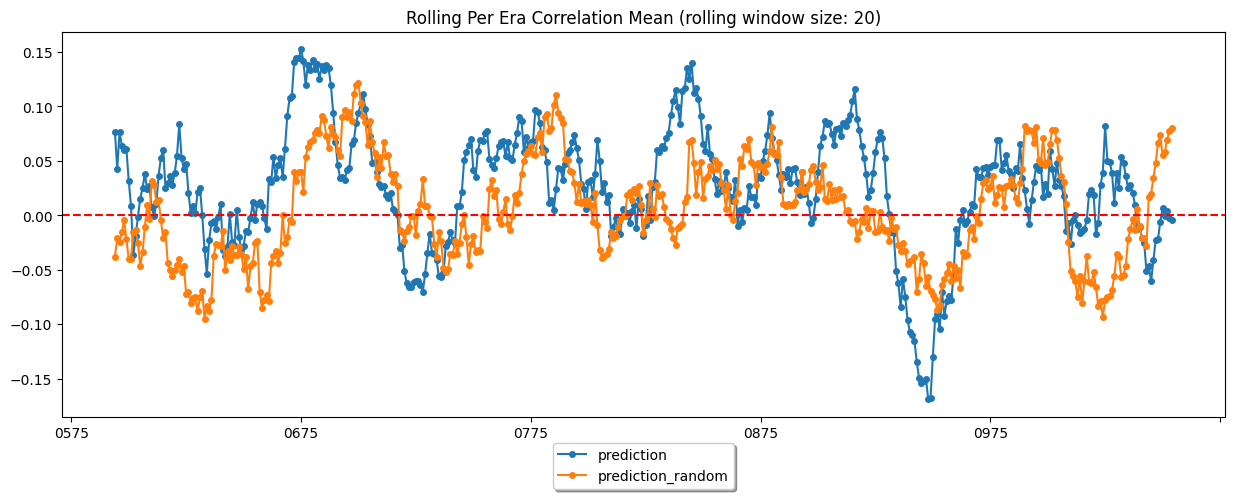

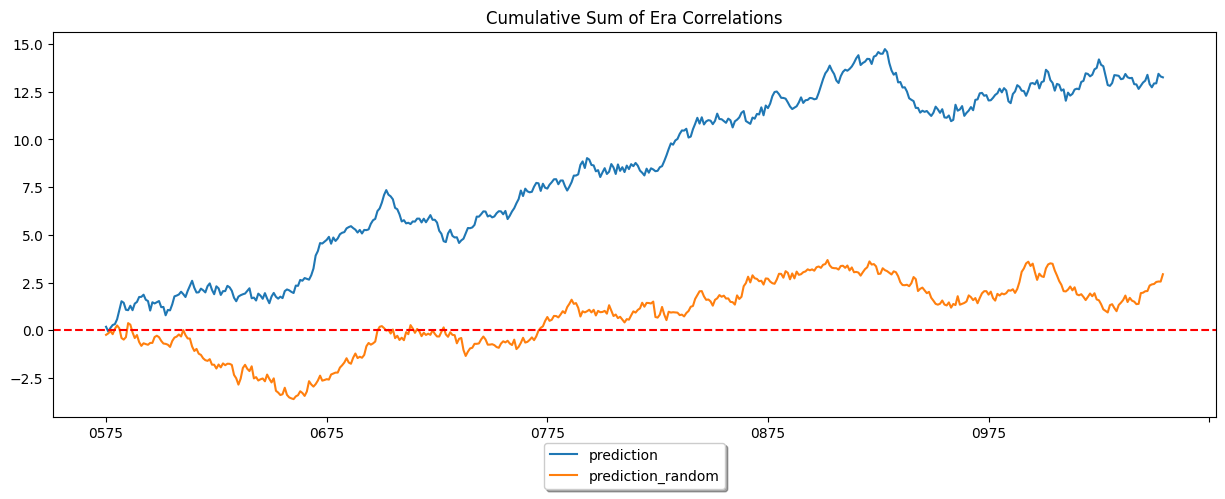

In [ ]:
#| eval: false
evaluator.plot_correlations(
    test_dataf.fillna(0.5), pred_cols=["prediction", "prediction_random"], roll_mean=20
)

In [ ]:
# Clean up environment
downloader.remove_base_directory()

⚠ Deleting directory for 'NumeraiClassicDownloader' ⚠
Path: '/home/clepelaars/numerblox/nbs/eval_test_1234321'

--------------------------------------------------